# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
import zipfile
import random
import re
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

$$\nabla_w L = \sum_{i=1}^{N} (\sigma(\mathbf{x}_i^T \mathbf{w}) - y_i)\mathbf{x}_{ij} + \gamma \text{sign}(\mathbf{w}) + 2\beta \mathbf{w}$${w}
\]


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    loss = 0
    for i in range(len(X)):
        dot_pr = np.dot(X[i], w)
        sg = 1 / (1+np.exp(-dot_pr))
        loss += -y[i] * np.log(sg) - (1-y[i]) * np.log(1 - sg)
    loss += gamma * np.sum(np.abs(w))
    loss += beta * np.sum(np.square(w))
    return loss

#### 3. [0.25 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w = []
    for j in range(len(w)):
        grad = 0
        for i in range(len(X)):
            dot_pr = np.dot(X[i], w)
            sg = 1 / (1+np.exp(-dot_pr))
            grad += (sg-y[i]) * X[i][j]
        grad += gamma * np.sign(w[j])
        grad += 2*beta * w[j]
        grad_w.append(grad)
    return grad_w

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
print(grad_w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

[-3.994474929359763, -1.8478672277855601, 0.6452010421087129, 1.6705997291223378, -5.0385848672792095, -5.214963362606359]


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        # you may additional properties if you wish
        self.loss_history = []

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps

        # your code here
        np.random.seed(self.random_state)
        N, k = X.shape
        self.w = np.random.randn(k + 1)
        for _ in range(self.max_iter):
            grad_w0, grad_w = get_grad(X, y, self.w[1:]) # finding the gradient
            self.w[0] -= self.lr*grad_w0 # new weights
            self.w[1:] -= self.lr*grad_w
            loss_curr = loss(X, y, self.w[1:])
            self.loss_history.append(loss_curr)
            if (len(self.loss_history) > 1) and (abs(self.loss_history[-1] - self.loss_history[-2]) < self.tolerance):
                break
        return self

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        # your code here
        return np.round(self.predict_proba(X))

    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        return 1 / (1+np.exp(-np.dot(X,self.w[1:])-self.w[0]))

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title('Decision boundary')

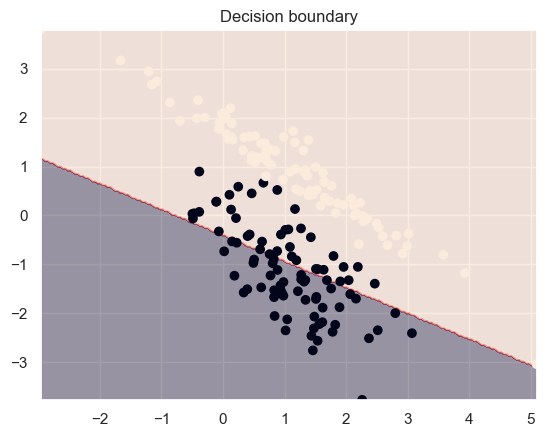

In [9]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

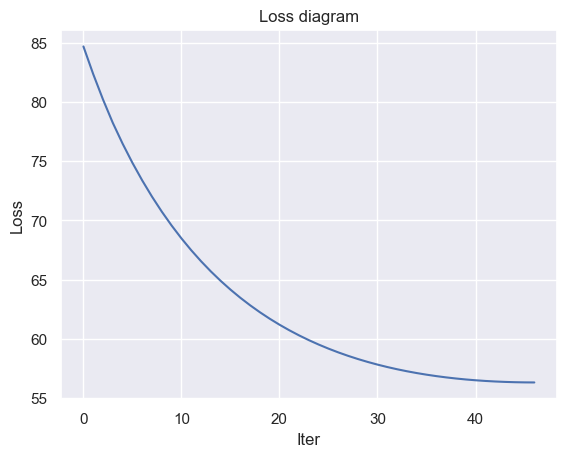

In [10]:
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.title('Loss diagram')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

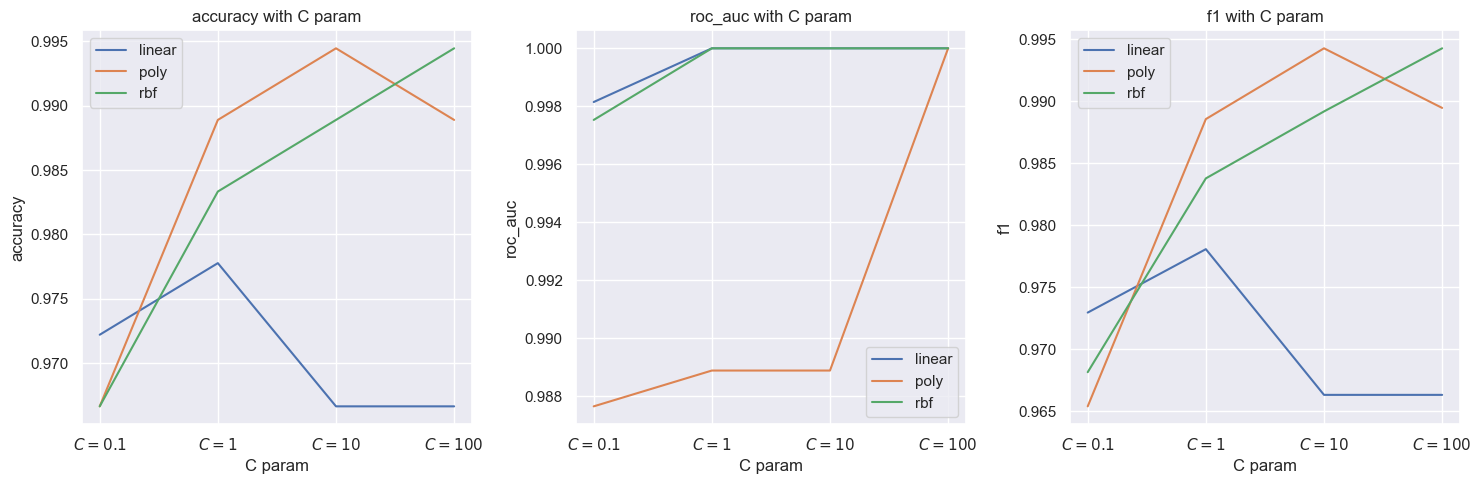

In [11]:
def evaluate_model(X, y, clf):
    acc = cross_val_score(clf, X, y, scoring='accuracy', cv=5).mean()
    ra = cross_val_score(clf, X, y, scoring='roc_auc', cv=5).mean()
    f1 = cross_val_score(clf, X, y, scoring='f1', cv=5).mean()
    return acc, ra, f1

X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2, random_state=42, n_clusters_per_class=1)
kernels = ['linear', 'poly', 'rbf'] # various kernels from the task
C_values = [0.1, 1, 10, 100]
metrics = {'accuracy': [], 'roc_auc': [], 'f1': []}
for kernel in kernels:
    for C_value in C_values:
        clf = SVC(kernel=kernel, C=C_value)
        acc, ra, f1 = evaluate_model(X, y, clf)
        metrics['accuracy'].append(acc)
        metrics['roc_auc'].append(ra)
        metrics['f1'].append(f1)
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
parameters = ['$C=0.1$', '$C=1$', '$C=10$', '$C=100$']
for i, metric in enumerate(metrics):
    axes[i].plot(parameters, metrics[metric][:4])
    axes[i].set_xlabel('C param')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} with C param')
    axes[i].legend(kernels)
for i, metric in enumerate(metrics):
    axes[i].plot(parameters, metrics[metric][4:8])
    axes[i].set_xlabel('C param')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} with C param')
    axes[i].legend(kernels)
for i, metric in enumerate(metrics):
    axes[i].plot(parameters, metrics[metric][8:12])
    axes[i].set_xlabel('C param')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} with C param')
    axes[i].legend(kernels)
plt.tight_layout()
plt.show()

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [12]:
# First of all, I'll kindly ask you to download the zip archives from here: https://github.com/ouzel/hw3_authors/tree/main

# Here is the process how I created them.
# I opened the zip archive using the github link provided in the task.
# Then I went to the prose folder and converted each of the folders to a zip archive, so it will be easier for me to upload them to jupyter.
# To sup up, these zip archives have exactly the same information as in the original github provided in the task.

def extract_data(zip_file, author):
    sentences = []
    targets = [] # for target authors
    with zipfile.ZipFile(zip_file, 'r') as zip: # opening the zip archives
        for file in zip.namelist():
            if file.endswith('.txt'): # to get rid of info.csv in each folder
                with zip.open(file) as f:
                    text = f.read().decode('utf-8')
                    sentences1 = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text) # splitting into sentences 
                    for sentence in sentences1:
                        if len(sentence.strip()) >= 15: # checking the number of symbols
                            sentences.append(sentence)
                            targets.append(author)
    df = pd.DataFrame({'sentence': sentences, 'author': targets}) # sentence - author
    return df

# Extracting data by author
# Chosen authors: Herzen, Tolstoy, Turgenev, Bryusov, Gorky, Lermontov
df_herzen = extract_data('Herzen.zip', 'Herzen')
df_tolstoy = extract_data('Tolstoy.zip', 'Tolstoy')
df_turgenev = extract_data('Turgenev.zip', 'Turgenev')
df_bryusov = extract_data('Bryusov.zip', 'Bryusov')
df_gorky = extract_data('Gorky.zip', 'Gorky')
df_lermontov = extract_data('Lermontov.zip', 'Lermontov')
df = pd.concat([df_herzen, df_tolstoy, df_turgenev, df_bryusov, df_gorky, df_lermontov], ignore_index=True)
random.seed(123)

proportions = [5000, 15000, 8000, 11000, 20000, 3000]
# proportions = [50, 150, 80, 110, 200, 30] -- this is a light version for testing

sampled_sentences = []
sampled_targets = []
for i in range(len(proportions)):
    sampled = random.sample(df[df['author'] == df['author'].unique()[i]]['sentence'].tolist(), proportions[i]) # according to the given proportions
    sampled_sentences.extend(sampled)
    sampled_targets.extend([df['author'].unique()[i]] * proportions[i])
df_sampled = pd.DataFrame({'sentence': sampled_sentences, 'author': sampled_targets}) # final version of a dataframe with proportions
display(df_sampled) # to see an extract of a dataframe
df_sampled = df_sampled.sample(frac=1).reset_index(drop=True) # shuffling so that sentences will be in random order (not grouped by authors)
df_sampled.to_csv('sampled_data.csv', index=False) # saving the dataframe to a file

,sentence,author
0,"Ни радоваться, ни удивляться; Ломбардия не мог...",Herzen
1,\n Веселая сельская жизнь Степана Степ...,Herzen
2,"Немощь, хилость старого общественного устройст...",Herzen
3,"Итак, биография дядюшки.",Herzen
4,"Ему было\nсемнадцать лет, когда он лишил...",Herzen
...,...,...
61995,"Посмотрите, доктор: видите ли вы, на скале на...",Lermontov
61996,"""Смотрите наверх! - шепнул я\nей, - это ничег...",Lermontov
61997,Ему это показалось странно.,Lermontov
61998,Вдали вилась пыль - Азамат скакал на лихом ...,Lermontov


In [13]:
import nltk
from nltk.corpus import stopwords

nltk.download()
# Kindly asking you to download from All packages -> punkt, stopwords, wordnet.
# Do not forget to close NLTK downloader so that the following code will work.

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [14]:
df_sampled["words"] = df_sampled["sentence"].apply(nltk.word_tokenize) # tokenizing
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation) # unfortunately – and -- were not extracted with this, so I added them separately
punctuation.add('–')
punctuation.add('--')
df_sampled["words"] = df_sampled["words"].apply(lambda x: [word.lower() for word in x if word.lower() not in stop_words and word.lower() not in punctuation and not word.isdigit()])

# Stemming could be added like this (commented code):
#stemmer = nltk.stem.PorterStemmer()
#df_sampled["stemmed_words"] = df_sampled["words"].apply(lambda x: [stemmer.stem(word) for word in x])

lemmatizer = nltk.stem.WordNetLemmatizer()
df_sampled["lemmatized_words"] = df_sampled["words"].apply(lambda x:[lemmatizer.lemmatize(word) for word in x])
display(df_sampled)

,sentence,author,words,lemmatized_words
0,"«И в самом деле, имение-то все сестрино!» – пр...",Turgenev,"[«, и, в, самом, деле, имение-то, все, сестрин...","[«, и, в, самом, деле, имение-то, все, сестрин..."
1,Маньковского // Наше наследие.,Bryusov,"[маньковского, //, наше, наследие]","[маньковского, //, наше, наследие]"
2,Он не скоро придет.,Tolstoy,"[он, не, скоро, придет]","[он, не, скоро, придет]"
3,Тотчас раздалось три удара.,Bryusov,"[тотчас, раздалось, три, удара]","[тотчас, раздалось, три, удара]"
4,"Мать обнял страх возможного столкновения, она ...",Gorky,"[мать, обнял, страх, возможного, столкновения,...","[мать, обнял, страх, возможного, столкновения,..."
...,...,...,...,...
61995,Они легко всплывали из глубины ее сердца и сла...,Gorky,"[они, легко, всплывали, из, глубины, ее, сердц...","[они, легко, всплывали, из, глубины, ее, сердц..."
61996,"Есть я или нет меня, вам все равно — наплевать.",Gorky,"[есть, я, или, нет, меня, вам, все, равно, —, ...","[есть, я, или, нет, меня, вам, все, равно, —, ..."
61997,"– Ну, брат, потешил! – кричал Обалдуй, не выпу...",Turgenev,"[ну, брат, потешил, кричал, обалдуй, не, выпус...","[ну, брат, потешил, кричал, обалдуй, не, выпус..."
61998,"Не в огне, а в грязи кипящей варить вас будут.",Gorky,"[не, в, огне, а, в, грязи, кипящей, варить, ва...","[не, в, огне, а, в, грязи, кипящей, варить, ва..."


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
vectorizer_bow = CountVectorizer()
bow_matrix = vectorizer_bow.fit_transform(df_sampled['lemmatized_words'].apply(lambda x: ' '.join(x)))
# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
tfidf_matrix = vectorizer_tfidf.fit_transform(df_sampled['lemmatized_words'].apply(lambda x: ' '.join(x)))

# Comparison of vectorizing
print("bag of words:")
print(bow_matrix[:10, :10].toarray().astype(float)) # displaying part of matrix (full version is too big)
print("tf-idf:")
print(tfidf_matrix[:10, :10].toarray().astype(float))  # displaying part of matrix (full version is too big)

bag of words:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
tf-idf:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [16]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

class MyGridSearchCV: # Custom GridSearchCV for my model
    def __init__(self, estimator, param_grid, scoring, cv):
        self.estimator = estimator
        self.param_grid = list(ParameterGrid(param_grid))
        self.scoring = scoring
        self.cv = cv

    def fit(self, X, y):
        best_score = None
        best_params = None

        for params in self.param_grid:
            self.estimator.init(**params)
            scores = []

            for train_index, test_index in KFold(n_splits=self.cv).split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                self.estimator.fit(X_train, y_train)
                y_pred = self.estimator.predict(X_test)
                score = f1_score(y_test, y_pred)
                scores.append(score)

            mean_score = np.mean(scores)

            if best_score is None or mean_score > best_score:
                best_score = mean_score
                best_params = params

        self.best_params_ = best_params

author
Herzen       5000
Lermontov    3000
Name: count, dtype: int64
0 stands for Herzen, 1 stands for Lermontov
F1 score for trained: 0.9924705213808781
F1 score for test: 0.84625


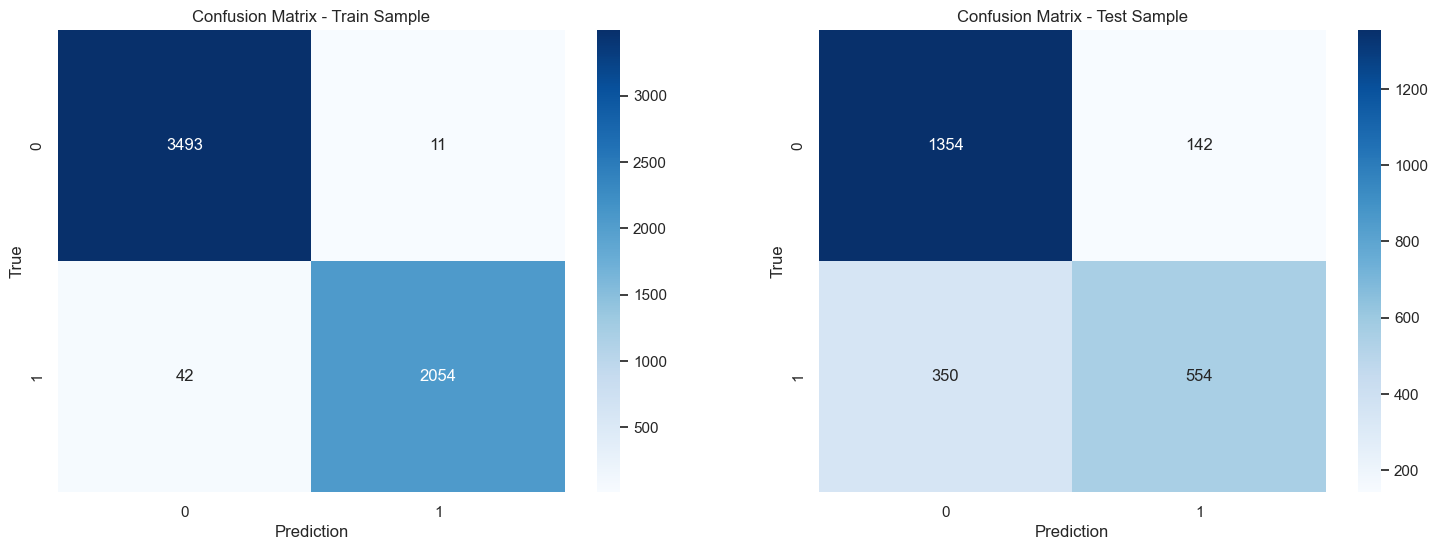

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1496
           1       0.80      0.61      0.69       904

    accuracy                           0.80      2400
   macro avg       0.80      0.76      0.77      2400
weighted avg       0.80      0.80      0.79      2400



In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')
vectorizer_tfidf = TfidfVectorizer()

author1 = 'Herzen'
author2 = 'Lermontov'
df_authors = df_sampled[(df_sampled['author'] == 'Herzen') | (df_sampled['author'] == 'Lermontov')]
class_balance = df_authors['author'].value_counts()
print(class_balance) #Checking the balance

X = vectorizer_tfidf.fit_transform(df_authors['lemmatized_words'].apply(lambda x: ' '.join(x)))
y = np.where(df_authors['author'] == 'Herzen', 0, 1) # for binary classification we'll need to convert authors to 0 and 1.
print("0 stands for Herzen, 1 stands for Lermontov")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training models
logit = Logit()
param_grid_logit = {'beta': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'lr': [1e-3, 1e-2, 1e-1]}
grid_search_logit = MyGridSearchCV(logit, param_grid_logit, scoring='f1', cv=5)
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_search = GridSearchCV(SVC(), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
model = SVC(**best_params)
model.fit(X_train, y_train)
#Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
f1_train = f1_score(y_train, y_pred_train, pos_label=0)
f1_test = f1_score(y_test, y_pred_test, pos_label=0)
print(f'F1 score for trained: {f1_train}')
print(f'F1 score for test: {f1_test}')
# Plotting results
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='RdPu', ax=ax[0])
ax[0].set_title('Confusion Matrix - Train Sample')
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('True')
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='RdPu', ax=ax[1])
ax[1].set_title('Confusion Matrix - Test Sample')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('True')
plt.show()
print(classification_report(y_test, y_pred_test))

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

Threshold for Log Reg = -0.70
Threshold for SVC = -0.46


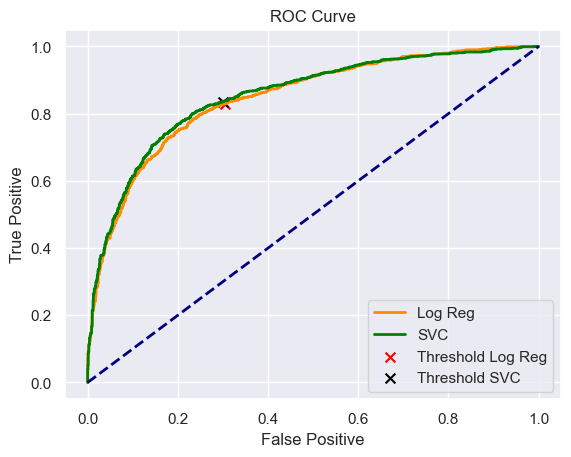

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_score_lr = lr.decision_function(X_test)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_score_svc = svc.decision_function(X_test)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_score_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plotting
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Log Reg')
plt.plot(fpr_svc, tpr_svc, color='green', lw=2, label='SVC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend()

# Thresholds
thr_index_lr = np.argmax(fpr_lr > 0.3)
thr_lr = thresholds_lr[thr_index_lr]
thr_index_svc = np.argmax(fpr_svc > 0.3)
thr_svc = thresholds_svc[thr_index_svc]
plt.scatter(fpr_lr[thr_index_lr], tpr_lr[thr_index_lr], s=50, c='red', marker='x', label='Threshold Log Reg')
plt.scatter(fpr_svc[thr_index_svc], tpr_svc[thr_index_svc], s=50, c='black', marker='x', label='Threshold SVC')
print('Threshold for Log Reg = %0.2f' % thr_lr)
print('Threshold for SVC = %0.2f' % thr_svc)
plt.legend()
plt.show()

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

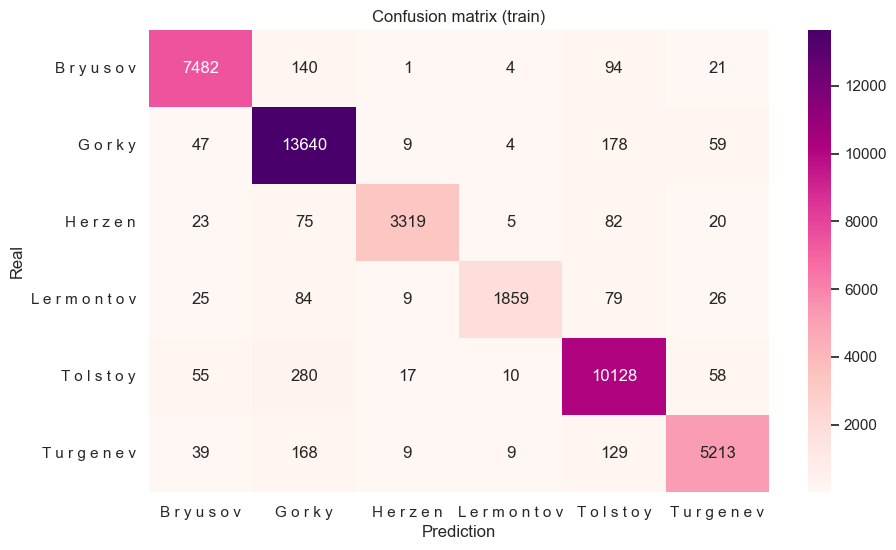

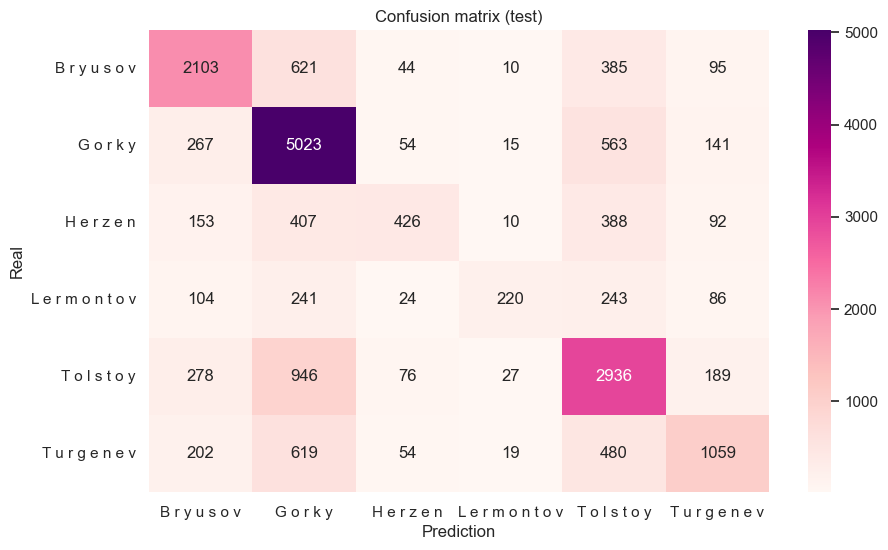

OneVsOne Log Reg:
                   precision    recall  f1-score   support

    B r y u s o v       0.68      0.65      0.66      3258
        G o r k y       0.64      0.83      0.72      6063
      H e r z e n       0.63      0.29      0.40      1476
L e r m o n t o v       0.73      0.24      0.36       918
    T o l s t o y       0.59      0.66      0.62      4452
  T u r g e n e v       0.64      0.44      0.52      2433

         accuracy                           0.63     18600
        macro avg       0.65      0.52      0.55     18600
     weighted avg       0.64      0.63      0.62     18600



In [20]:
import warnings
warnings.filterwarnings('ignore')
X = tfidf_matrix
y = df_sampled['author'].apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ovo_classifier = OneVsOneClassifier(LogisticRegression())
param_grid = {'estimator__C': [0.1, 1, 10], 'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear']}
grid_search = GridSearchCV(ovo_classifier, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = ovo_classifier.set_params(**best_params)
best_model.fit(X_train, y_train)

def plot_confusion_matrix(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel('Prediction')
    plt.ylabel('Real')
    plt.show()

plot_confusion_matrix(best_model, X_train, y_train, 'Confusion matrix (train)')
plot_confusion_matrix(best_model, X_test, y_test, 'Confusion matrix (test)')
y_pred = best_model.predict(X_test)
print('OneVsOne Log Reg:')
print(classification_report(y_test, y_pred))